# IMPORTING LIBRARIES

In [ ]:
# Google Drive Integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities
from collections import Counter

# LOADING DATASETS

In [ ]:
manual_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Cleaned_Manually_Labelled_Reviews.csv')
roberta_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Labelled_Reviews.csv')
trad_manual_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Baseline_ManualPredictions.csv')
trad_roberta_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Baseline_RobertaPredictions.csv')
hyb_manual_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Hybrid_ManualPredictions.csv')
hyb_roberta_df = pd.read_csv('/content/drive/MyDrive/Dissertation24/Hybrid_RobertaPredictions.csv')

In [ ]:
roberta_df['at'] = pd.to_datetime(roberta_df['at'], format='%Y-%m-%d')

# VISUALISATIONS

In [ ]:
# Set the Seaborn theme for all plots
sns.set_theme(style="whitegrid")

<ipython-input-15-b19b5320f0f7>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([label_mapping[label] for label in ax2.get_xticks()])


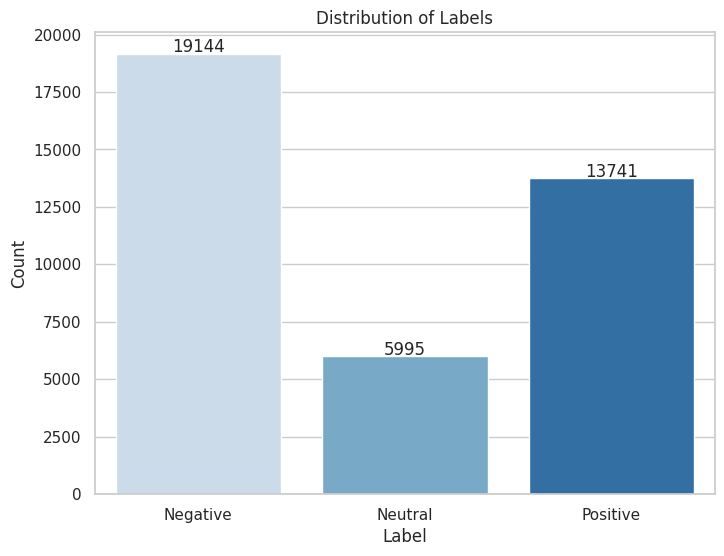

In [ ]:
def plot_label_distribution(data):
    label_palette = sns.color_palette("Blues", 3)
    label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    plt.figure(figsize=(8, 6))
    ax2 = sns.countplot(x='label', data=data, hue='label', palette=label_palette, legend=False)

    for p in ax2.patches:
        ax2.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points')

    ax2.set_xticklabels([label_mapping[label] for label in ax2.get_xticks()])

    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_label_distribution(roberta_df)

<ipython-input-16-41ab9e5b0439>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x='score', data=data, palette=score_palette)


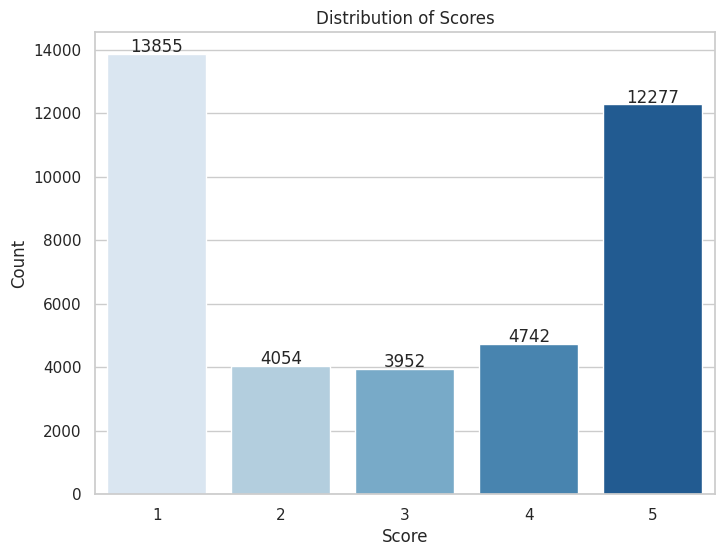

In [ ]:
def plot_score_distribution(data):
    score_palette = sns.color_palette("Blues", len(data['score'].unique()))

    plt.figure(figsize=(8, 6))
    ax1 = sns.countplot(x='score', data=data, palette=score_palette)

    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points')

    plt.title('Distribution of Scores')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()

plot_score_distribution(roberta_df)

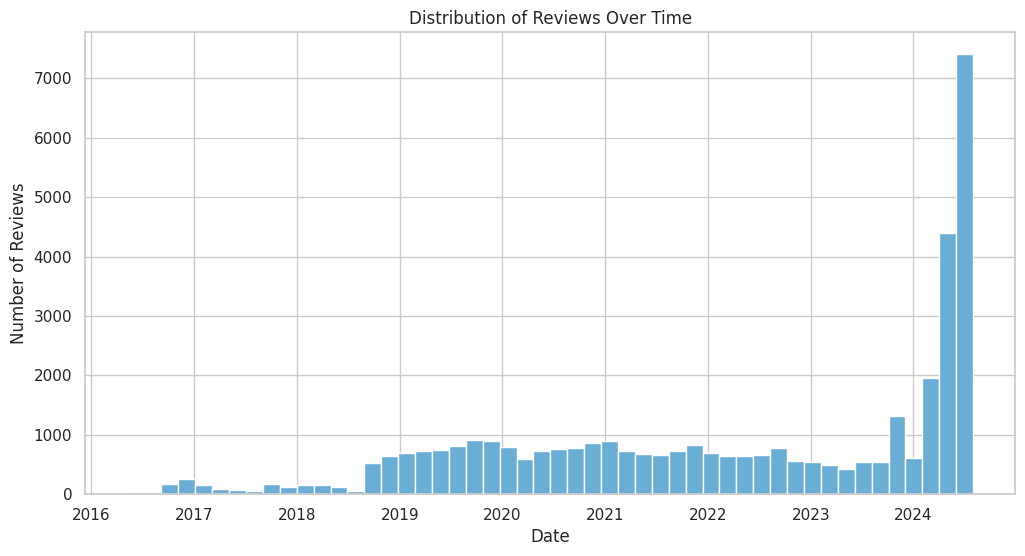

In [ ]:
def plot_distribution_of_reviews_over_time(df):
    plt.figure(figsize=(12, 6))
    df['at'].hist(bins=50, color=sns.color_palette("Blues", 1)[0])

    plt.title('Distribution of Reviews Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.show()

plot_distribution_of_reviews_over_time(roberta_df)

<Figure size 1200x600 with 0 Axes>

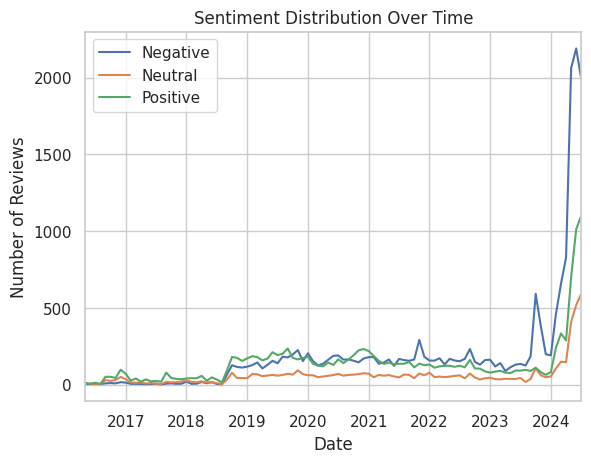

In [ ]:
def plot_sentiment_distribution_over_time(df):
    plt.figure(figsize=(12, 6))
    df.set_index('at').resample('M')['label'].value_counts().unstack().plot(kind='line')

    plt.title('Sentiment Distribution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.legend(['Negative', 'Neutral', 'Positive'])
    plt.show()

plot_sentiment_distribution_over_time(roberta_df)

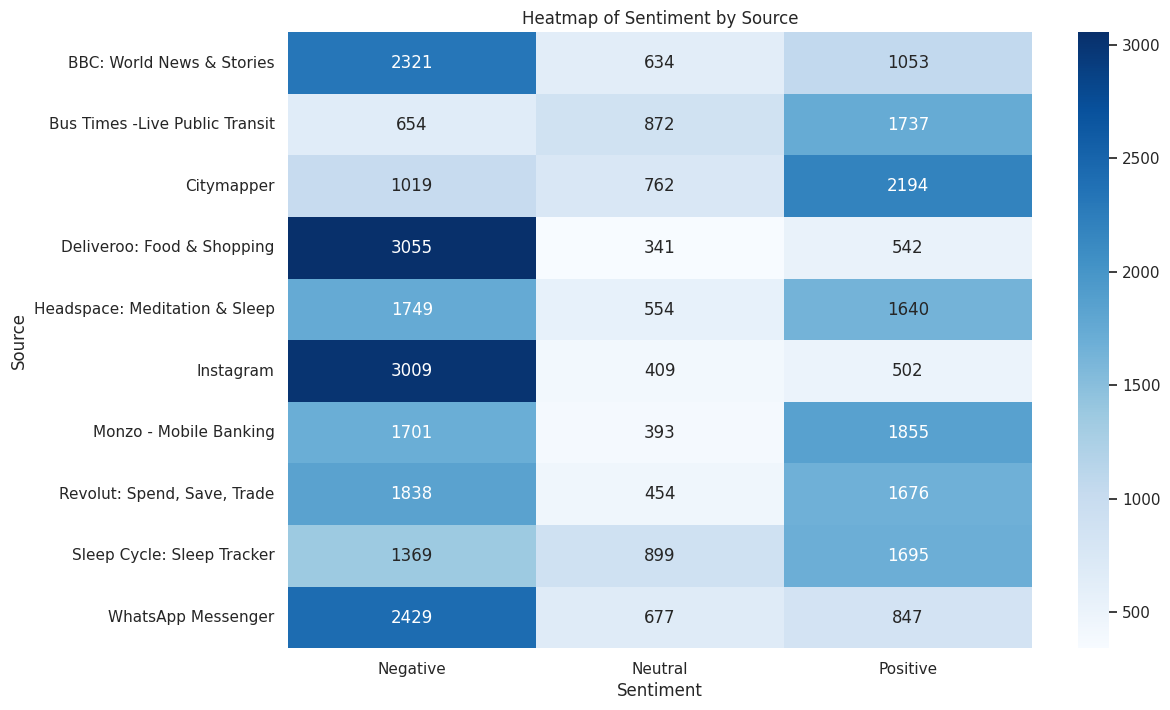

In [ ]:
def plot_sentiment_by_source_heatmap(df):
    sentiment_by_source_heatmap = df.groupby(['source', 'label']).size().unstack().fillna(0)
    sentiment_by_source_heatmap.columns = ['Negative', 'Neutral', 'Positive']

    plt.figure(figsize=(12, 8))
    sns.heatmap(sentiment_by_source_heatmap, annot=True, fmt='g', cmap='Blues')

    plt.title('Heatmap of Sentiment by Source')
    plt.xlabel('Sentiment')
    plt.ylabel('Source')
    plt.show()

plot_sentiment_by_source_heatmap(roberta_df)

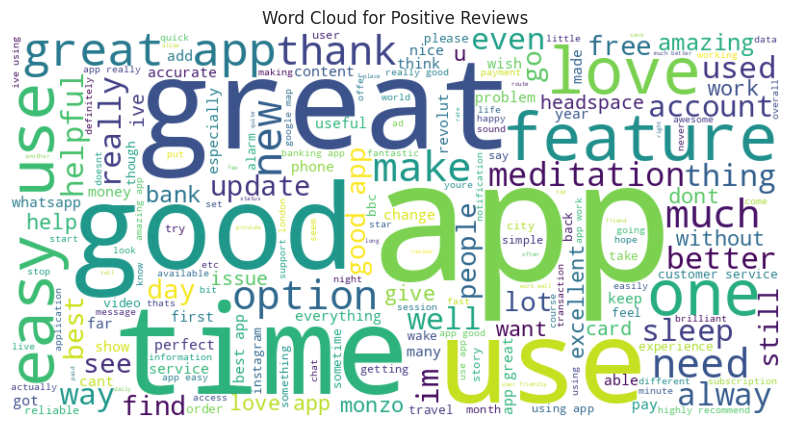

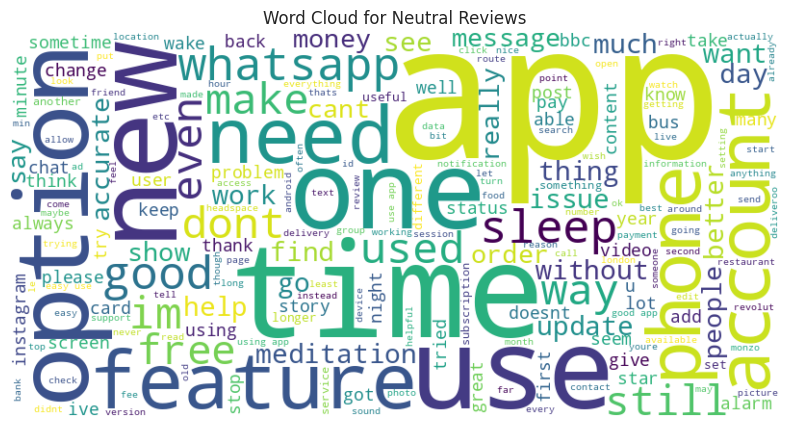

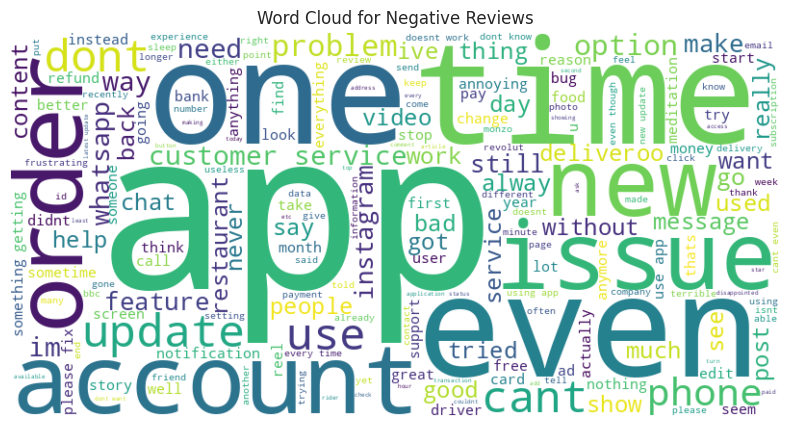

In [ ]:
def plot_generate_wordcloud(df, sentiment_label):
    text = " ".join(review for review in df[df['label'] == sentiment_label]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {"Positive" if sentiment_label == 2 else "Neutral" if sentiment_label == 1 else "Negative"} Reviews')
    plt.show()

plot_generate_wordcloud(roberta_df, 2)  # Positive reviews
plot_generate_wordcloud(roberta_df, 1)  # Neutral reviews
plot_generate_wordcloud(roberta_df, 0)  # Negative reviews

<ipython-input-22-d1a930911066>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=features, palette='Blues')


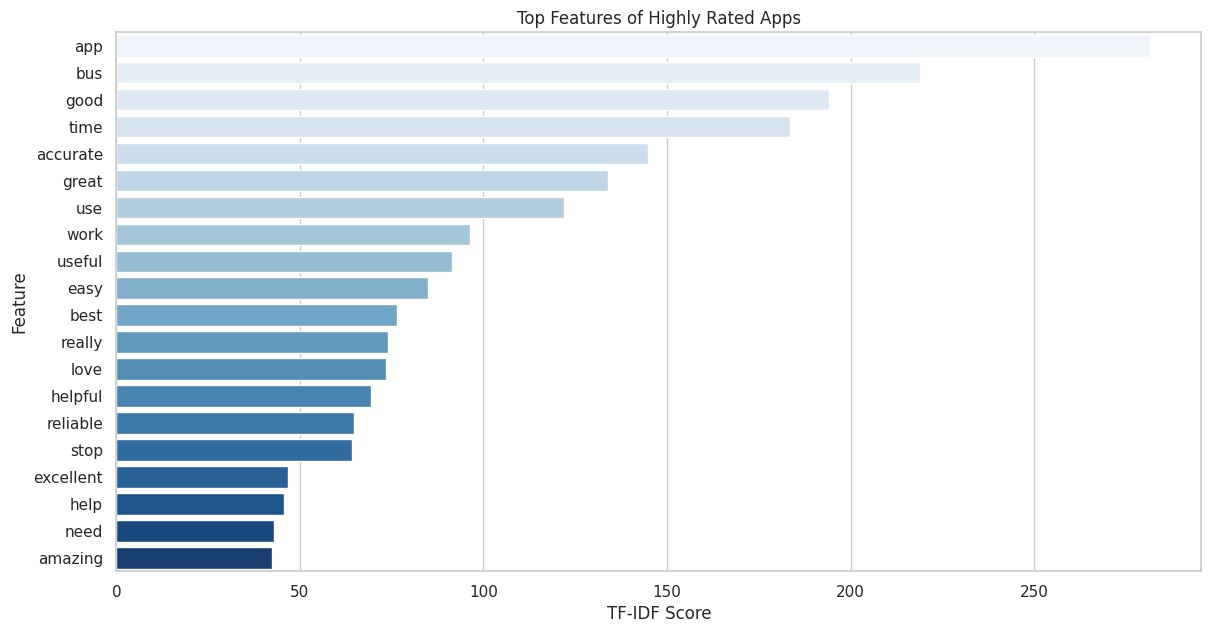

<ipython-input-22-d1a930911066>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=features, palette='Blues')


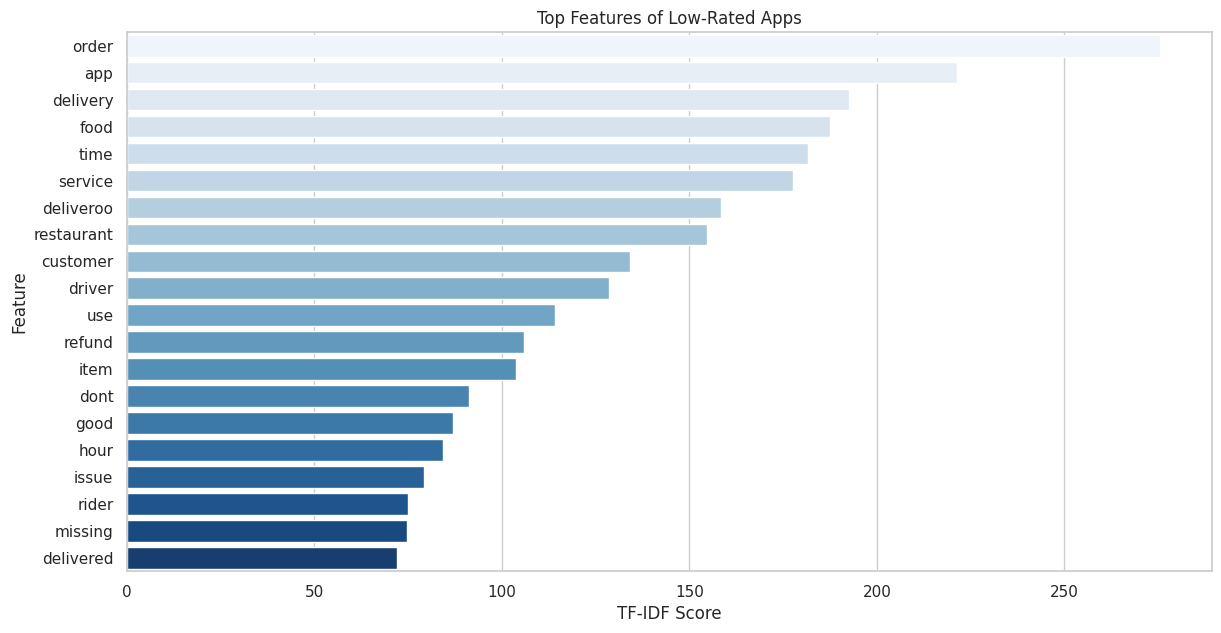

In [ ]:
def calculate_average_scores(df, high_threshold=4.0, low_threshold=2.0):
    average_scores = df.groupby('source')['score'].mean().reset_index()

    high_rated_apps = average_scores[average_scores['score'] >= high_threshold]['source']
    low_rated_apps = average_scores[average_scores['score'] <= low_threshold]['source']

    high_rated_reviews = df[df['source'].isin(high_rated_apps)]['content']
    low_rated_reviews = df[df['source'].isin(low_rated_apps)]['content']

    return high_rated_reviews, low_rated_reviews

def get_top_features(reviews, n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(reviews)

    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.sum(axis=0).A1

    tfidf_freq = dict(zip(feature_names, tfidf_scores))
    top_features = pd.DataFrame(sorted(tfidf_freq.items(), key=lambda x: x[1], reverse=True), columns=['Feature', 'Score']).head(n)

    return top_features

def plot_top_features(features, title):
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Score', y='Feature', data=features, palette='Blues')
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Feature')
    plt.show()

def plot_main(roberta_df):
    high_rated_reviews, low_rated_reviews = calculate_average_scores(roberta_df)

    top_high_features = get_top_features(high_rated_reviews)
    top_low_features = get_top_features(low_rated_reviews)

    plot_top_features(top_high_features, 'Top Features of Highly Rated Apps')
    plot_top_features(top_low_features, 'Top Features of Low-Rated Apps')

plot_main(roberta_df)

<ipython-input-21-2290d9984547>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='score', y='source', data=sorted_average_scores, palette='viridis')


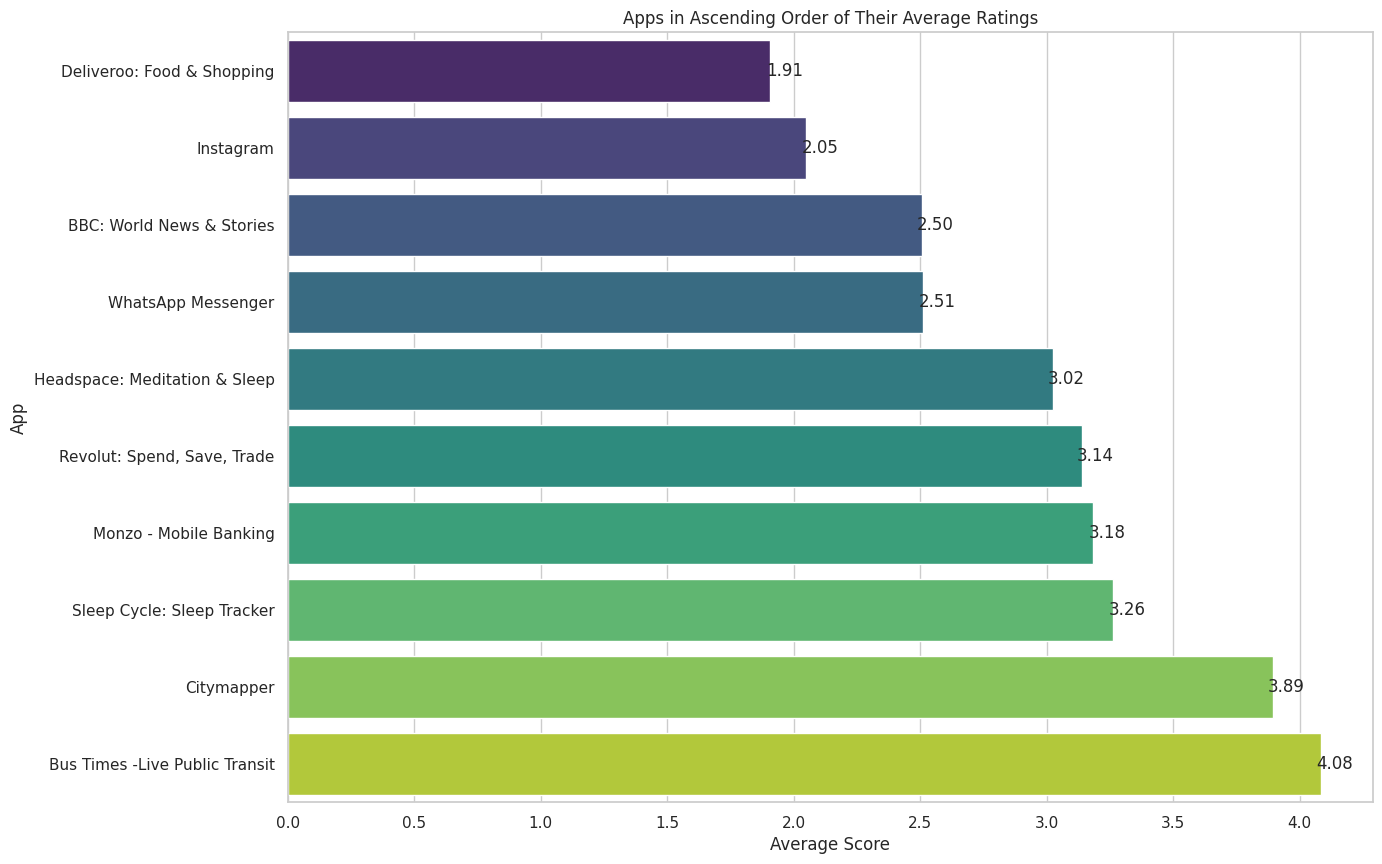

In [ ]:
def plot_average_scores(df):
    average_scores = df.groupby('source')['score'].mean().reset_index()
    sorted_average_scores = average_scores.sort_values(by='score')

    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='score', y='source', data=sorted_average_scores, palette='viridis')

    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center', xytext=(10, 0), textcoords='offset points')

    plt.title('Apps in Ascending Order of Their Average Ratings')
    plt.xlabel('Average Score')
    plt.ylabel('App')
    plt.yticks(rotation=0)
    plt.show()

plot_average_scores(roberta_df)

<ipython-input-30-794ef81c477f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='Blues')


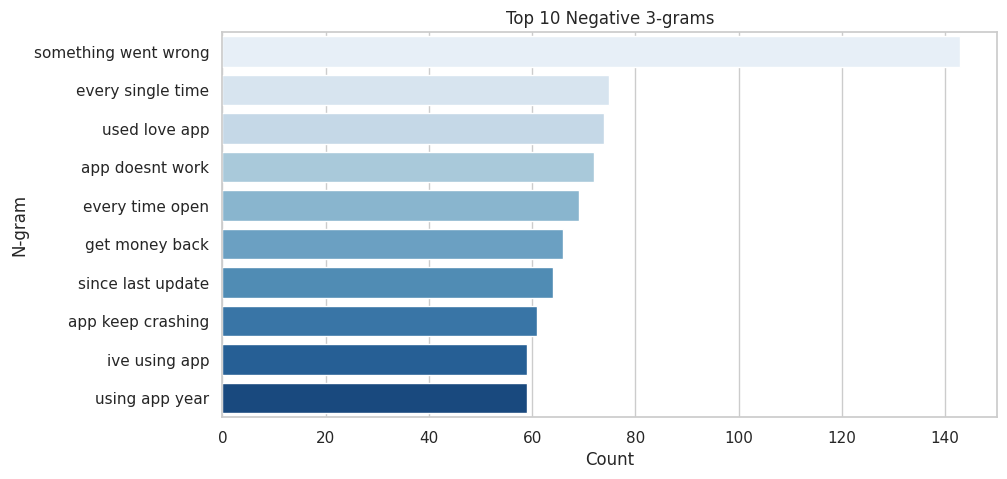

<ipython-input-30-794ef81c477f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='Blues')


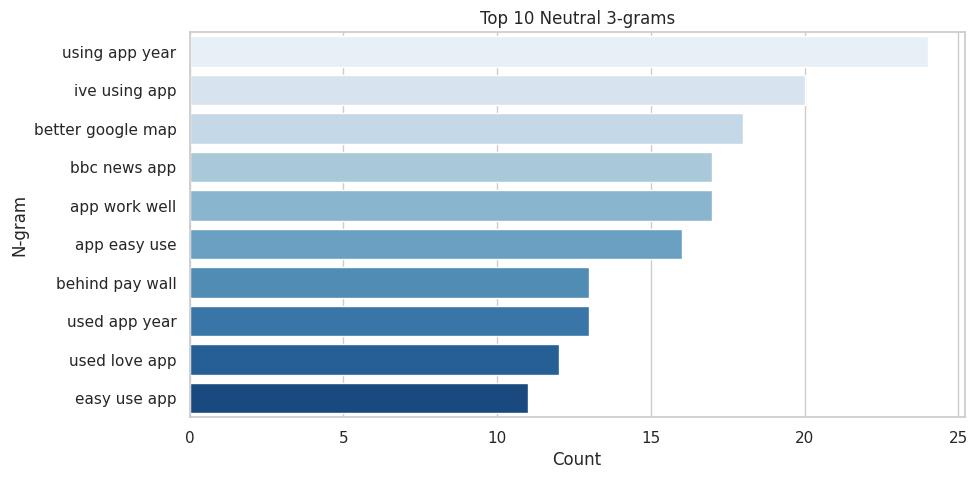

<ipython-input-30-794ef81c477f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='Blues')


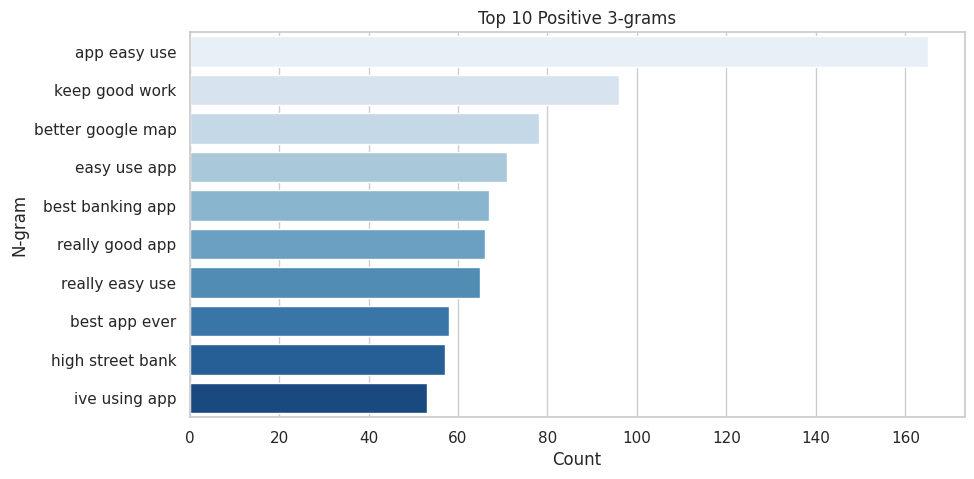

In [ ]:
def plot_ngrams(words, counts, title='Top N-grams'):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words, palette='Blues')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.show()

def analyze_ngrams_for_sentiment(texts, n=3, sentiment='Sentiment'):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, counts = zip(*words_freq[:10])
    plot_ngrams(words, counts, title=f'Top 10 {sentiment} {n}-grams')

def plot_analyze_ngrams_by_sentiment(roberta_df, n=3):
    for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
        texts = roberta_df[roberta_df['label'] == label]['content']
        analyze_ngrams_for_sentiment(texts, n=n, sentiment=sentiment)

plot_analyze_ngrams_by_sentiment(roberta_df, n=3)

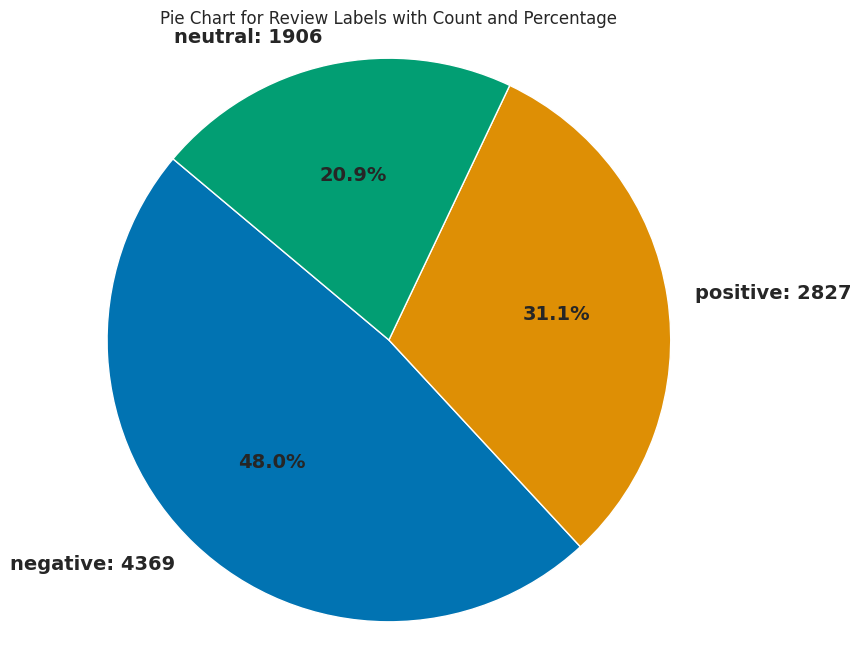

In [ ]:
def plot_pie_chart(data, column, colors=None, title="Pie Chart for Review Labels with Count and Percentage"):
    pie_data = data[column].value_counts()
    pie_data = pie_data.sort_values(ascending=False)
    stages = pie_data.index.tolist()
    values = pie_data.values

    if colors is None:
        colors = sns.color_palette("colorblind", len(stages))

    labels_with_data = [f'{stage}: {value}' for stage, value in zip(stages, values)]
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(values, labels=labels_with_data, autopct='%1.1f%%', colors=colors, startangle=140,
           textprops={'fontsize': 14, 'fontweight': 'bold'})

    ax.axis('equal')
    plt.title(title)
    plt.show()

plot_pie_chart(manual_df, 'label')

<ipython-input-33-7cb3d1b91057>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='trigram', data=top_trigrams, palette='Blues')


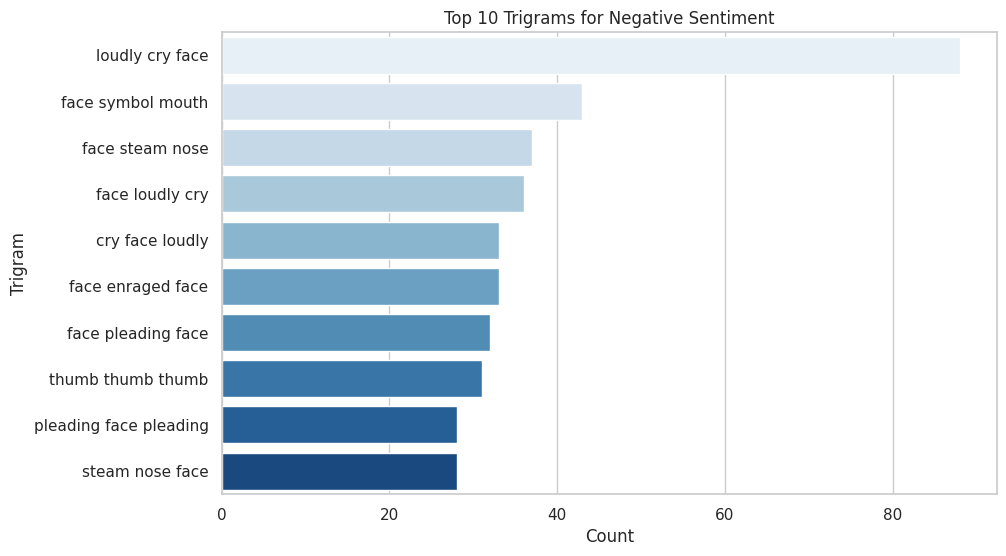

<ipython-input-33-7cb3d1b91057>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='trigram', data=top_trigrams, palette='Blues')


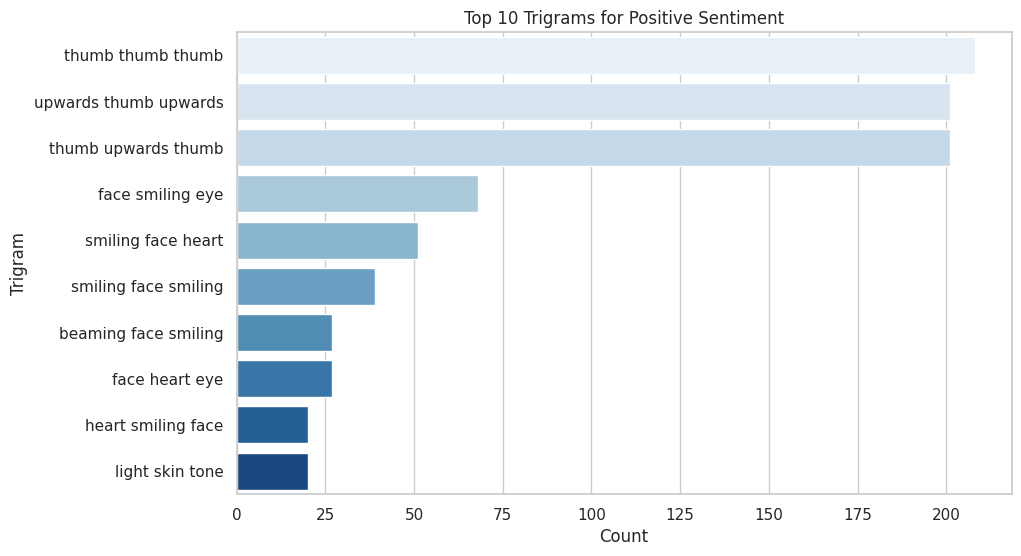

<ipython-input-33-7cb3d1b91057>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='trigram', data=top_trigrams, palette='Blues')


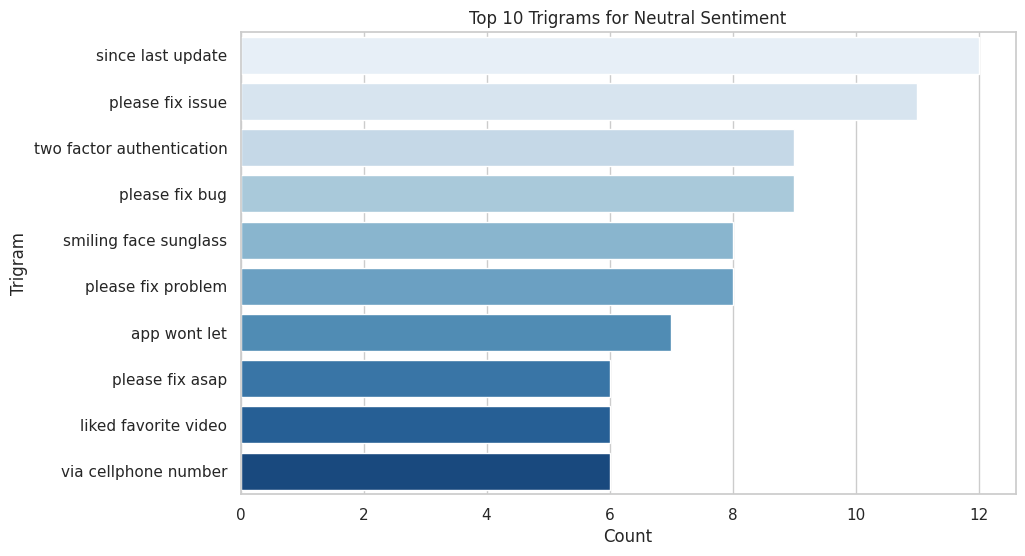

In [ ]:
def plot_top_trigrams(df, sentiment_label, n=10):
    sentiment_text = df[df['label'] == sentiment_label]['content']

    vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=1000)
    X = vectorizer.fit_transform(sentiment_text)

    trigrams = X.sum(axis=0)
    trigrams = trigrams.A1
    vocab = vectorizer.get_feature_names_out()
    trigram_counts = pd.DataFrame({'trigram': vocab, 'count': trigrams})
    top_trigrams = trigram_counts.sort_values(by='count', ascending=False).head(n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='trigram', data=top_trigrams, palette='Blues')
    plt.title(f'Top {n} Trigrams for {sentiment_label.capitalize()} Sentiment')
    plt.xlabel('Count')
    plt.ylabel('Trigram')
    plt.show()

plot_top_trigrams(manual_df, 'negative')
plot_top_trigrams(manual_df, 'positive')
plot_top_trigrams(manual_df, 'neutral')


==========TRADITIONAL MODELS: PREDICTED LABELS FOR MANUAL LABELLED DATASET==========



<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


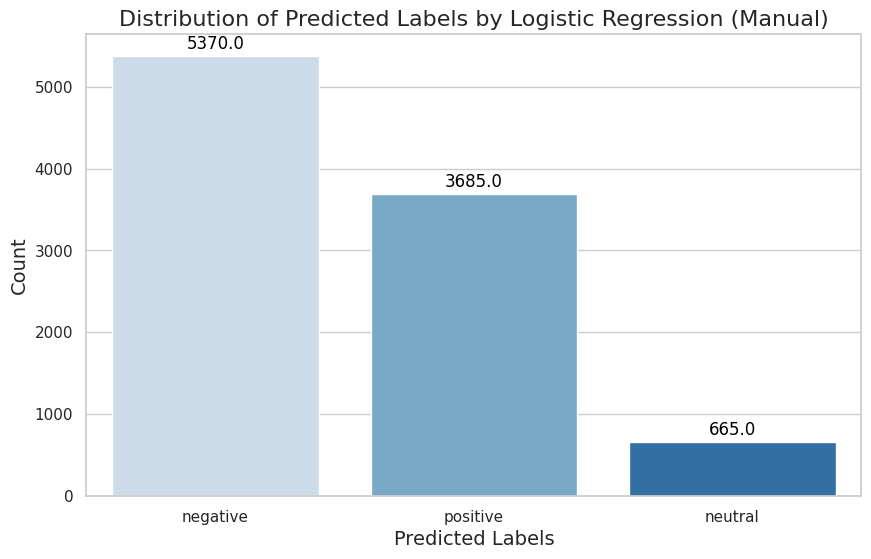

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


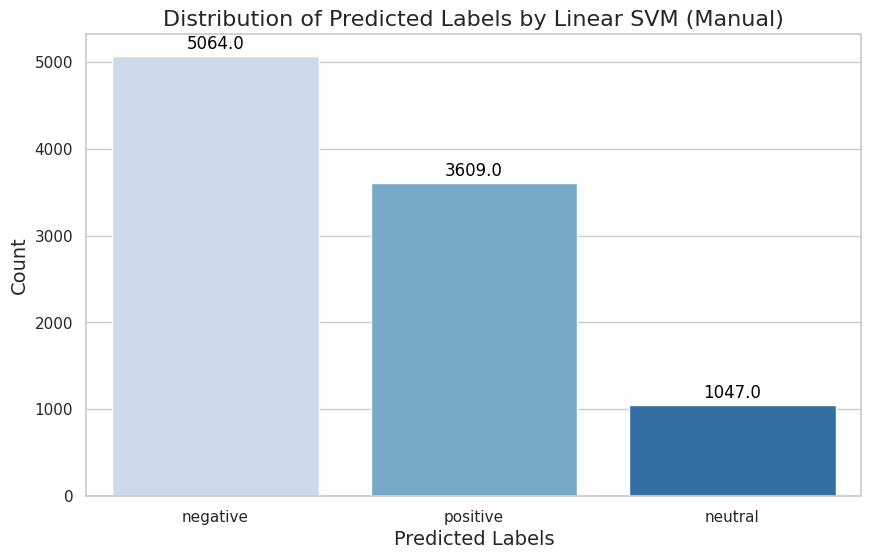

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


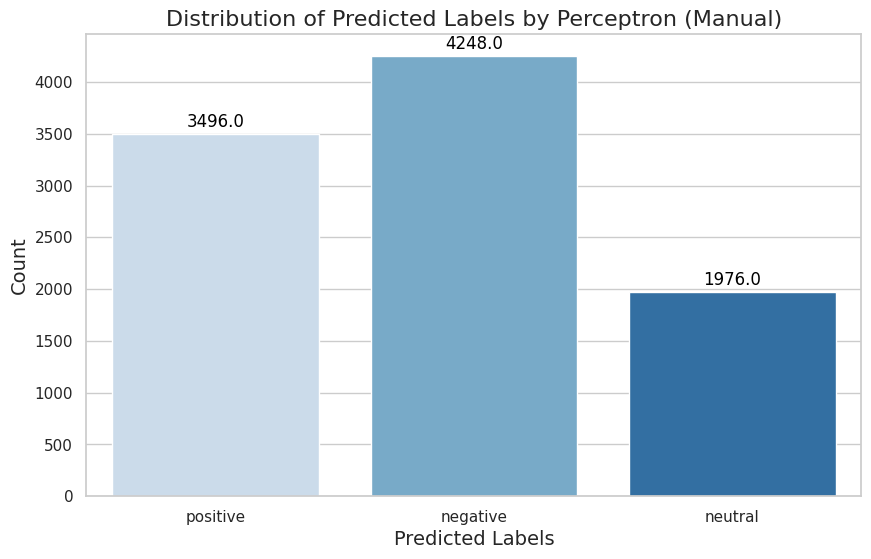

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


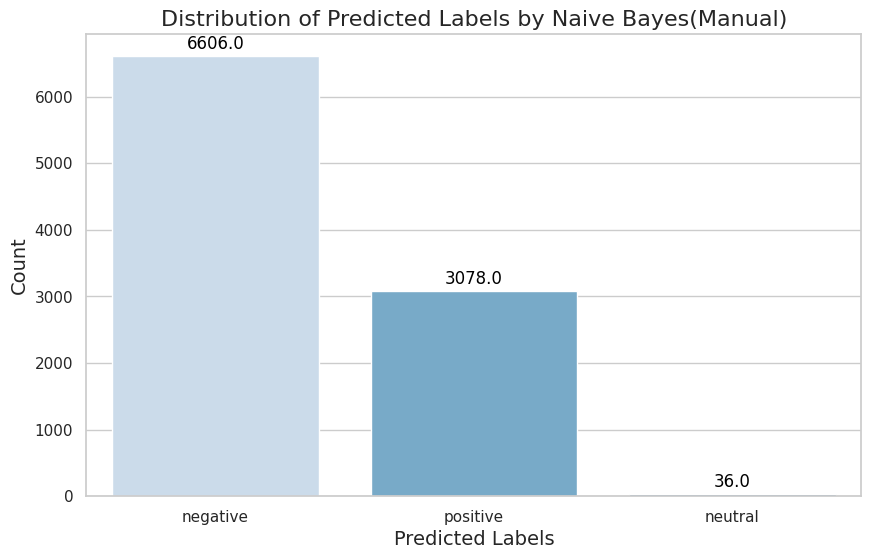

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


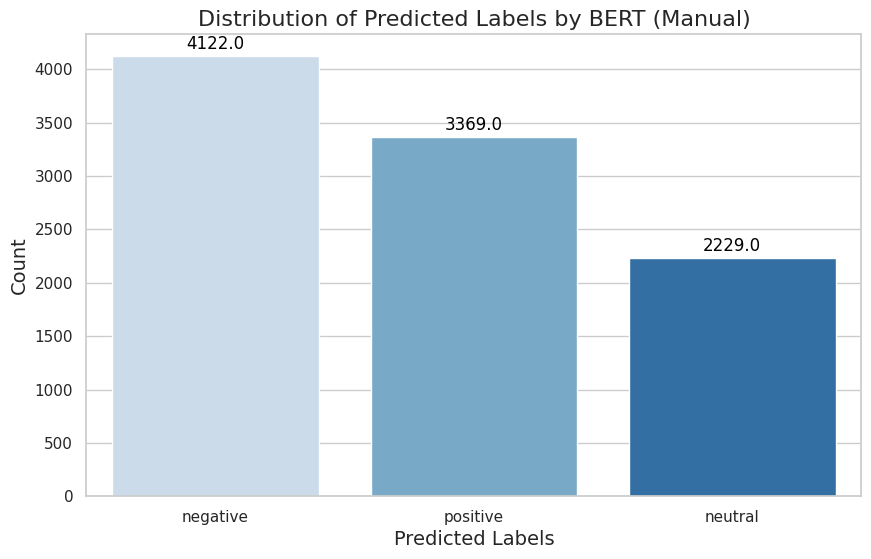


==========TRADITIONAL MODELS: PREDICTED LABELS FOR ROBERTA LABELLED DATASET==========



<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


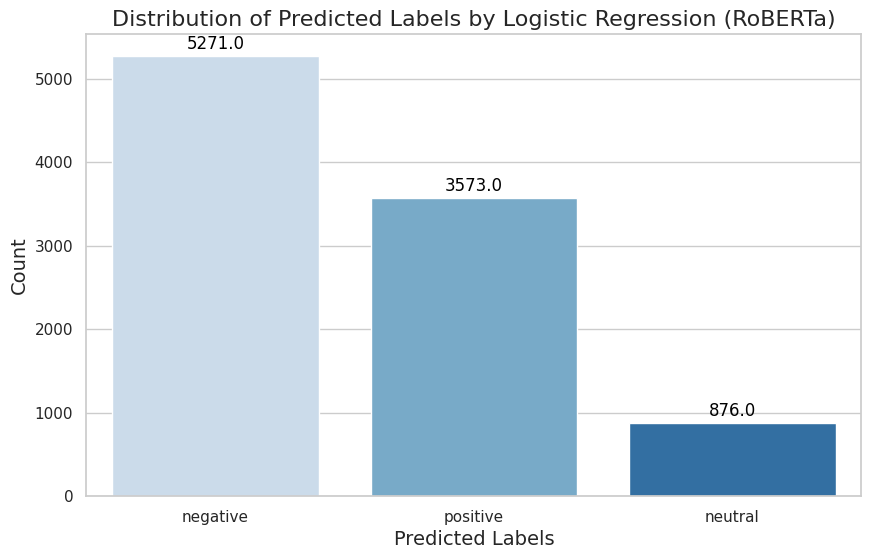

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


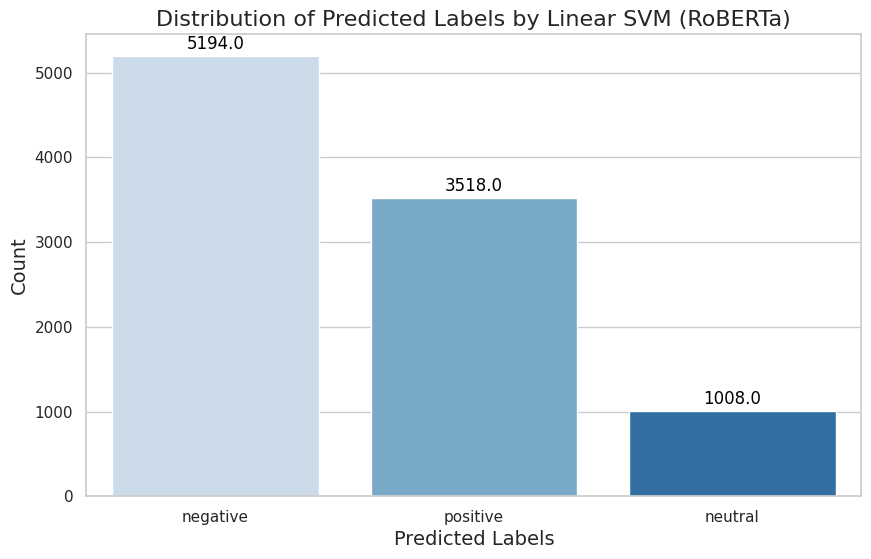

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


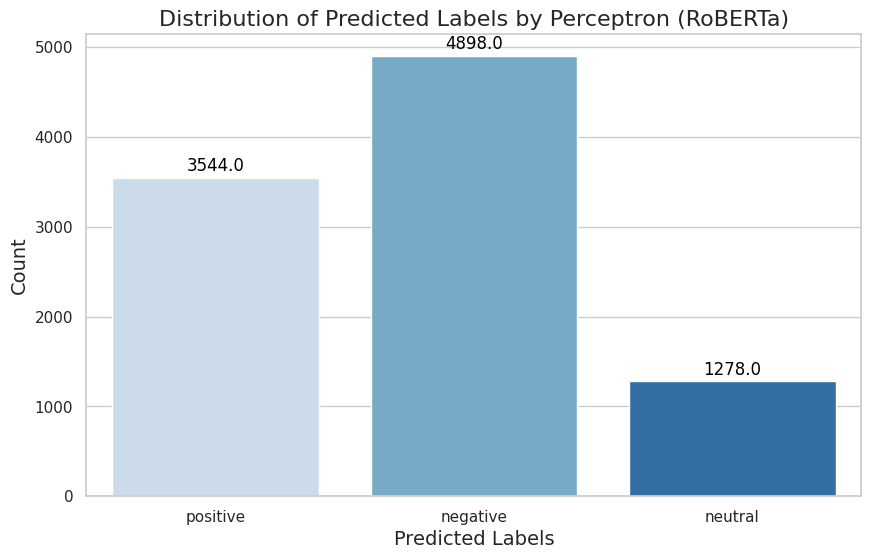

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


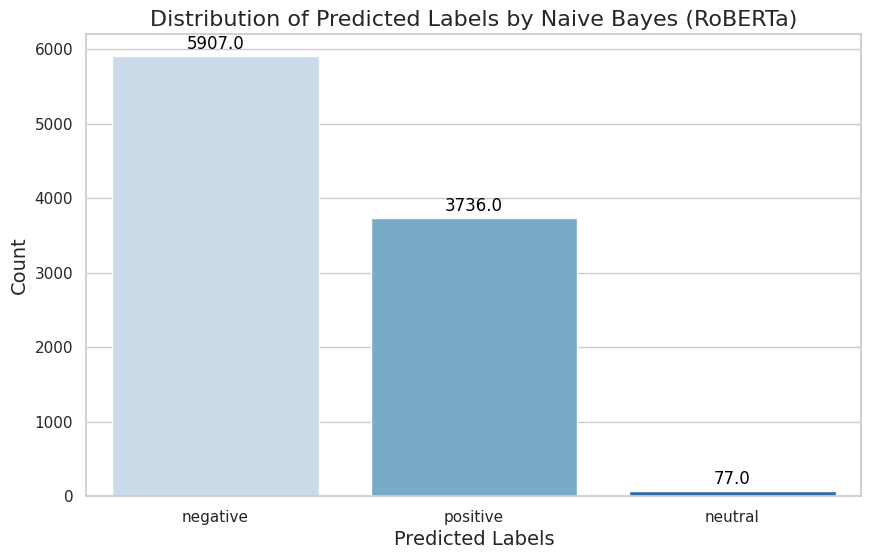

<ipython-input-40-31597a9fb9b3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column_name, data=data, palette='Blues')


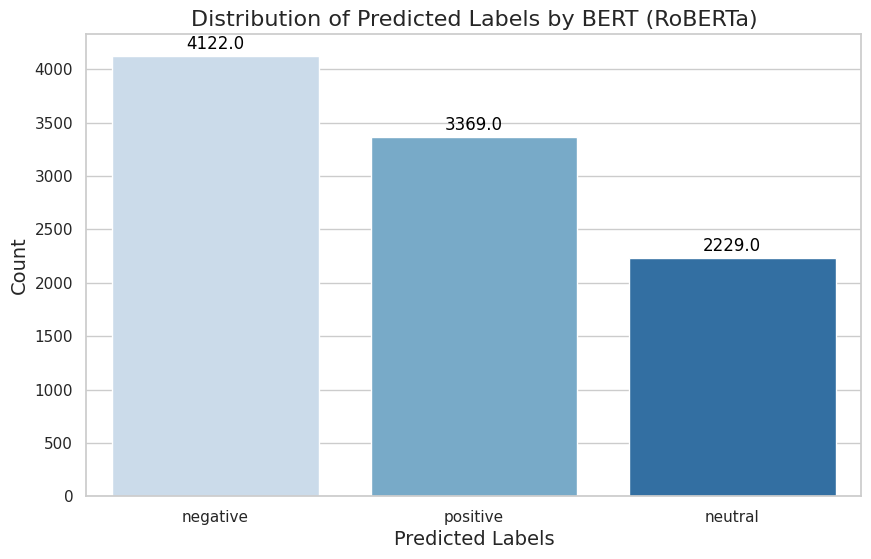

In [ ]:
def plot_predicted_labels_distribution(data, column_name, model_name):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=column_name, data=data, palette='Blues')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.title(f'Distribution of Predicted Labels by {model_name}', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.show()

# Usage of the function with different models
print("========================================================================================")
print("\n==========TRADITIONAL MODELS: PREDICTED LABELS FOR MANUAL LABELLED DATASET==========\n")
print("========================================================================================")
plot_predicted_labels_distribution(trad_manual_df, 'Logistic_Regression_pred', 'Logistic Regression (Manual)')
plot_predicted_labels_distribution(trad_manual_df, 'Linear_SVM_pred', 'Linear SVM (Manual)')
plot_predicted_labels_distribution(trad_manual_df, 'Perceptron_pred', 'Perceptron (Manual)')
plot_predicted_labels_distribution(trad_manual_df, 'Naive_Bayes_pred', 'Naive Bayes(Manual)')
plot_predicted_labels_distribution(trad_manual_df,'BERT_pred', 'BERT (Manual)')
print("========================================================================================")
print("\n==========TRADITIONAL MODELS: PREDICTED LABELS FOR ROBERTA LABELLED DATASET==========\n")
print("========================================================================================")
plot_predicted_labels_distribution(trad_roberta_df, 'Logistic_Regression_pred', 'Logistic Regression (RoBERTa)')
plot_predicted_labels_distribution(trad_roberta_df, 'Linear_SVM_pred', 'Linear SVM (RoBERTa)')
plot_predicted_labels_distribution(trad_roberta_df, 'Perceptron_pred', 'Perceptron (RoBERTa)')
plot_predicted_labels_distribution(trad_roberta_df, 'Naive_Bayes_pred', 'Naive Bayes (RoBERTa)')
plot_predicted_labels_distribution(trad_manual_df,'BERT_pred', 'BERT (RoBERTa)')

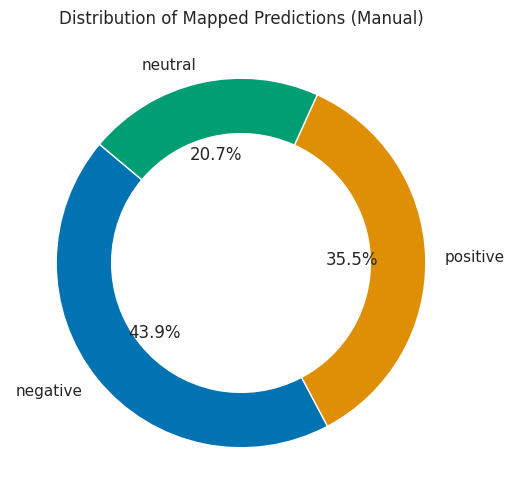

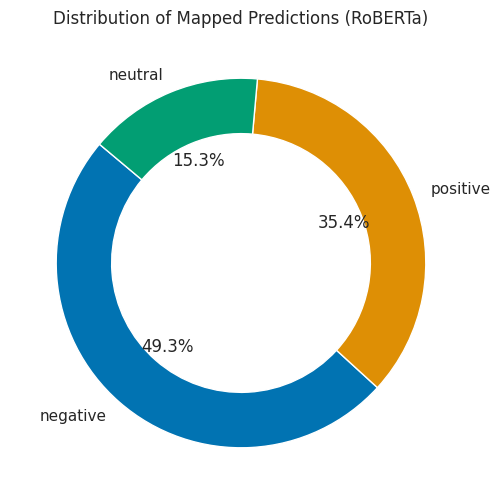

In [ ]:
def plot_mapped_predictions_donut_chart(predictions, colors=None, title="Distribution of Mapped Predictions"):
    label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    mapped_predictions = [label_mapping[label] for label in predictions]

    if colors is None:
        colors = sns.color_palette("colorblind", len(label_mapping))

    mapped_prediction_counts = Counter(mapped_predictions)
    labels, counts = zip(*mapped_prediction_counts.items())

    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'width': 0.3})
    plt.title(title)
    plt.show()

plot_mapped_predictions_donut_chart(hyb_manual_df['label'], title="Distribution of Mapped Predictions (Manual)")
plot_mapped_predictions_donut_chart(hyb_roberta_df['label'], title="Distribution of Mapped Predictions (RoBERTa)")